# Final Project Prototype - Chest X-ray Image Classification

## Import Packages and Functions

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from matplotlib import image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
 

## Data Exploration

In [2]:
#Listing the files
def ListFiles(link):
    return (len([name for name in os.listdir(link)]))

In [3]:
#Giving variable names to each file
TrainNormal = ListFiles('Downloads/chest_xray/train/NORMAL')
TrainPneumonia = ListFiles('Downloads/chest_xray/train/PNEUMONIA')
TestNormal = ListFiles('Downloads/chest_xray/test/NORMAL')
TestPneumonia = ListFiles('Downloads/chest_xray/test/PNEUMONIA')

In [4]:
# Dataframe for labels in train set
TrainBar = pd.DataFrame({'# of images':[TrainNormal,TrainPneumonia], 'labels':['Normal', 'Pneumonia']})
display(TrainBar)

,# of images,labels
0,1349,Normal
1,3883,Pneumonia


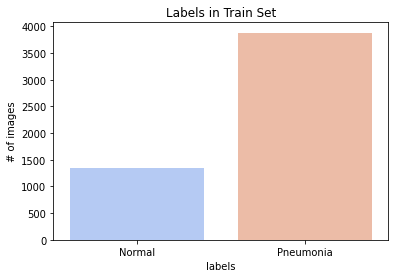

In [5]:
# Barplot for the labels in train Set
sns.barplot(y = '# of images', x = 'labels', 
            data = TrainBar,
            palette=("coolwarm")).set_title('Labels in Train Set');

In [6]:
# Dataframe for test set 
TestBar = pd.DataFrame({'# of images':[TestNormal,TestPneumonia], 'labels':['normal', 'pneumonia']})
display(TestBar)

,# of images,labels
0,234,normal
1,390,pneumonia


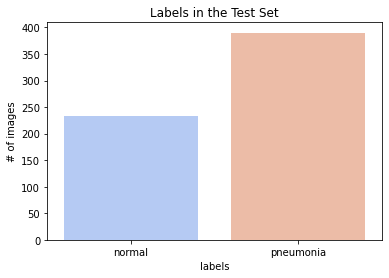

In [7]:
# Barplot for test set
sns.barplot(y = '# of images', x = 'labels', 
            data = TestBar,
            palette=("coolwarm")).set_title('Labels in the Test Set');

Showing Random Normal Images


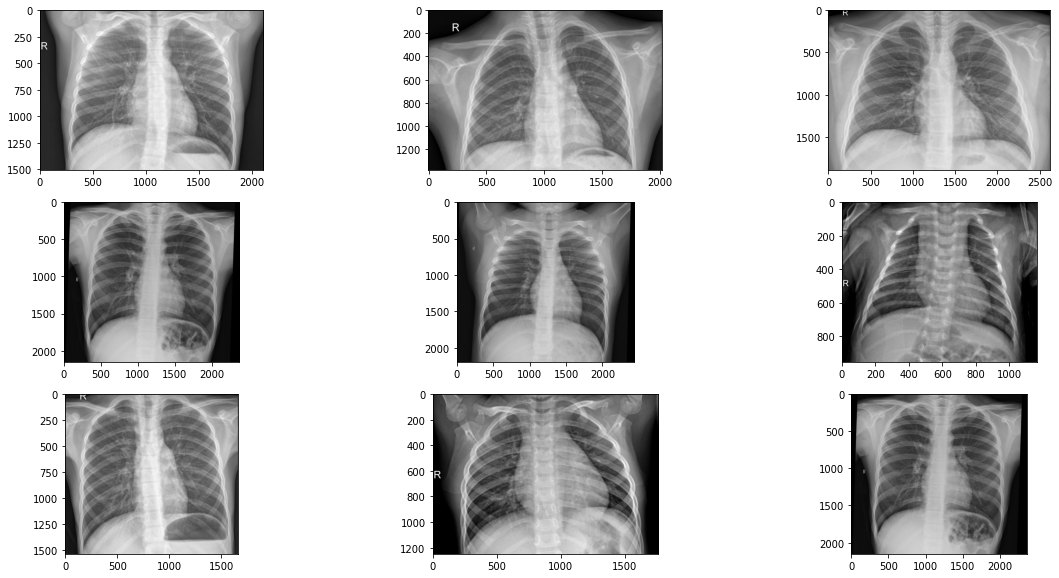

In [8]:
# Extract Test Normal Images
images = [name for name in os.listdir('Downloads/chest_xray/test/NORMAL')]

# Numpy Random Choice
np.random.seed(42)
random_images = [np.random.choice(images, replace = False) for i in range(9)]

# Location of the image dir
img_dir = 'Downloads/chest_xray/test/NORMAL'

print('Showing Random Normal Images')

# Rescaling the image size
plt.figure(figsize=(20,10))

# Process random images
for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir,random_images[i]))
    plt.imshow(img,cmap='gray')  

The Maximum Pixel Value: 255.0000       The Minimum Pixel Value: 0.0000
The Mean Value of the Pixels: 107.9319  The Standard Deviation: 63.4316


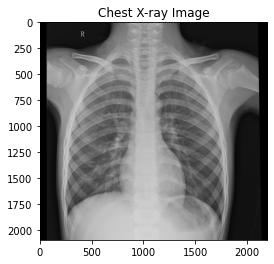

In [9]:
# Pick the 1st Test Normal Image
first_image = images[0]
img1 = plt.imread(os.path.join(img_dir,first_image))
plt.imshow(img1,cmap='gray')

pixels = image.imread(os.path.join(img_dir,first_image))

plt.title('Chest X-ray Image')


# print(f"The dimensions of the image are {img1.width} pixels width and {img1.height} pixels height, mode of the image is {img.mode}")
print(f"The Maximum Pixel Value: {pixels.max():.4f}       The Minimum Pixel Value: {pixels.min():.4f}")
print(f"The Mean Value of the Pixels: {pixels.mean():.4f}  The Standard Deviation: {pixels.std():.4f}")

## Preprocessing of Image with Keras ImageDataGenerator

In [10]:
# Create ImageDataGenerator
TestDatagen = ImageDataGenerator(
    samplewise_center = True, 
    samplewise_std_normalization = True, 
    rescale = 1./255)

TrainDatagen = ImageDataGenerator(
    samplewise_center = True, # Set Sample Mean to 0.
    samplewise_std_normalization = True, # Class images by its standard deviation
    rotation_range = 10, # Degree of Rotations
    width_shift_range = 0.1, # Total Width Rotation
    height_shift_range = 0.1,# Total Height Rotation
    rescale = 1./255, # Scale the pixels to [0,1]
    validation_split = 0.2) # Part of images for validation


In [11]:
#Load images

TestGenerator = TestDatagen.flow_from_directory(
    directory=r"Downloads/chest_xray/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode=None,
    shuffle=False,
    seed = 42
)


TrainGenerator = TrainDatagen.flow_from_directory(
    directory=r"Downloads/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "training",
    seed=42
)




ValidGenerator = TrainDatagen.flow_from_directory(
    directory=r"Downloads/chest_xray/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    subset = "validation",
    seed=42
)



Found 624 images belonging to 2 classes.
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


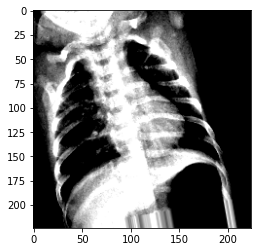

In [12]:
# Show first preprocessed image
x, y = TrainGenerator.__getitem__(0)
plt.imshow(x[0]);

## Class Imbalance

In [13]:
# Using this formula to solve the class imbalance problem because number of Pneumonia label is higher than normal
initial_bias = np.log([TrainPneumonia/TrainNormal])
initial_bias

array([1.05724447])

## Implementing CNN Model (DenseNet-121)

In [14]:
# Set the seeds
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

# Base Trained Model
BaseModel = DenseNet121(weights='imagenet', input_shape = (224, 224, 3), include_top = False)

#Freeze .
BaseModel.trainable = False

inputs = keras.Input(shape= (224, 224, 3))

# Base model should run inference mode by passing training=False for fine-tuning
x = BaseModel(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'sigmoid', 
                             bias_initializer=keras.initializers.Constant(initial_bias)
)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.Recall())
                     

In [15]:
EarlyStoppingCallback = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

model.fit(TrainGenerator, 
         validation_data = ValidGenerator,
          steps_per_epoch = 100,      
          validation_steps = 400, 
          callbacks = EarlyStoppingCallback,
          epochs = 1000)

Epoch 1/1000
100/100 [==============================] - 312s 3s/step - loss: 0.3613 - recall: 0.9652 - val_loss: 0.2483 - val_recall: 0.9497


## Checking the Performance

In [16]:
# Treshold Function
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

In [17]:
def ModelAssesment(model):
    predicted_vals = model.predict(TestGenerator, steps = len(TestGenerator))
    vfunc = np.vectorize(treshold)
    predictions = vfunc(predicted_vals)
    accuracy = accuracy_score(TestGenerator.classes, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(TestGenerator.classes, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(TestGenerator.classes, predictions)
    print('Precision Score : %f' % precision)
    print()
    recall = recall_score(TestGenerator.classes, predictions)
    print('Recall Score: %f' % recall)
    print()
    print('Confusion Matrix')
    cm = confusion_matrix(y_true = TestGenerator.classes, y_pred=predictions)
    print(cm)

In [18]:
ModelAssesment(model)

Accuracy: 0.841346

F1 score: 0.881437

Precision Score : 0.826966

Recall Score: 0.943590

Confusion Matrix
[[157  77]
 [ 22 368]]


Model 95-97% correctly detect the abnormality